In [ ]:
"""
1. the program to try to find objects that we might be interested in
2. making different cut for our region of interests 
    2.1 cube cut: checking whether each dot is inside our region
    2.2 ellisoid cut: draw an ellisiod and check each dot
    2.3 verticle cut: draw a line for all the more extreme objects (we are using this one)
Input: /Users/taweewat/Documents/xray_project/result/rosat-rad-final3.csv
"""

In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib import cm
import matplotlib

import pandas as pd
import numpy as np
import csv
import sys

from astropy.io import ascii
import mpld3
from mpld3 import plugins, utils

#my own library for deg_hr, hr_deg
from ch_py import *

%matplotlib inline
pylab.rcParams['figure.figsize'] = 8, 5
#mpld3.enable_notebook()
#mpld3.disable_notebook()

In [2]:
#function to remove all non-numbers characters into Nan
def func(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

In [7]:
hr_deg('15h59m11.9s', '+20d45m31s')
deg_hr(0.11,0.333)

'0h0m26.40s +0d19m58.80s'

## Set up the Final Database

In [63]:
final = pd.read_csv('/Users/taweewat/Documents/xray_project/result/rosat-rad-final3.csv',\
                    keep_default_na=False, na_values=[""])
print final.shape, final.dropna().shape

(9784, 35) (3528, 35)


In [6]:
alpha=-1.3
ratio=(1.4/0.843)**alpha
#final.columns
final['df_radio_n'] = final['df_radio']
final.loc[final['flag']==2,'df_radio_n'] = final.loc[final['flag']==2,'df_radio']*ratio

#Convert w1, ew1 to flux 
#convert Mab = Mvega+2.699 Jy, erg s-1 cm-2 Hz-1
final.loc[:,'wi_f']=3631.*1.0e-23*10.**(-(final.loc[:,'w4']+6.620)/2.5) # F0=3631 Jy, 
final.loc[:,'ewi_f']=3631.*1.0e-23*(10.**(-(final.loc[:,'w4']+final.loc[:,'ew4']+6.620)/2.5)-\
                                    10.**(-(final.loc[:,'w4']-final.loc[:,'ew4']+6.620)/2.5))/2.0  

#convert j_m, ej_m to flux, (J: F0=1594 Jy), (H: F0=1024 Jy), (K: F0=666.7) erg s-1 cm-2 Hz-1
final.loc[:,'2m_f']=666.7*1.0e-23*10.**(-(final.loc[:,'k_m'])/2.5)
final.loc[:,'e2m_f']=666.7*1.0e-23*(10.**(-(final.loc[:,'k_m']+final.loc[:,'ek_m'])/2.5)-\
                                    10.**(-(final.loc[:,'k_m']-final.loc[:,'ek_m'])/2.5))/2.0

#convert ROSAT to flux
#final.loc[:,'x_f']=final.loc[:,'xc']*5.6e-12/1.45e18 #(2.3 keV/h = 1.45e18 Hz)
final.loc[:,'x_f']=final.loc[:,'xc']*1.0e-11/5.56e17 #(2.3 keV/h = 5.56e17 Hz)
final.loc[:,'ex_f']=final.loc[:,'exc']*1.0e-11/5.56e17

#convert Radio data
final.loc[:,'rad_f']=final.loc[:,'f_radio_n']*1.0e-3*1.0e-23
final.loc[:,'erad_f']=final.loc[:,'df_radio_n']*1.0e-3*1.0e-23

#define new columns
final['xray']=np.log10(final['x_f'].values)-np.log10(final['2m_f'].values)
final['mir']=np.log10(final['wi_f'].values)-np.log10(final['2m_f'].values)
final['radio']=np.log10(final['rad_f'].values)-np.log10(final['2m_f'].values)

final['exray']=((0.434*final['ex_f']/final['x_f'])**2+(0.434*final['e2m_f']/final['2m_f'])**2)**0.5
final['emir']=((0.434*final['ewi_f']/final['wi_f'])**2+(0.434*final['e2m_f']/final['2m_f'])**2)**0.5
final['eradio']=((0.434*final['erad_f']/final['rad_f'])**2+(0.434*final['e2m_f']/final['2m_f'])**2)**0.5

In [7]:
final['RA']=(final['ra']+final['ra_radio'])/2.
final['DEC']=(final['dec']+final['dec_radio'])/2.

In [8]:
final.to_csv('/Users/taweewat/Documents/xray_project/result/rosat-rad-final-01.csv', index=False)

## Define Objects

In [2]:
final = pd.read_csv('/Users/taweewat/Documents/xray_project/result/rosat-rad-final-01.csv',\
                    keep_default_na=False, na_values=[""])
print final.shape, final.dropna().shape

(9784, 52) (3528, 52)


In [3]:
# Brightness Cutoff for k_m > 9 mag
final=final[final['k_m']>9.]
#final=final[final['dist'].values*3600.<20.0]
print final.shape, final.dropna().shape

(6897, 52) (3408, 52)


In [4]:
x=final
#ra='ra_radio'
#dec='dec_radio'

#target=x.loc[(((x.loc[:,'ra']-ra_x)**2+(x.loc[:,'dec']-dec_x)**2)**0.5).idxmin(),:]

In [5]:
i=0
if i==0:
    #our cluster
    ra_x=209.02268
    dec_x=-34.35293
elif i==1:
    #Bullet cluster (found)
    ra_x=104.6292
    dec_x=-55.9469
elif i==2:
    #Abell 2744/Pandora's Cluster (not found)
    ra_x=3.5792
    dec_x=-30.3894
elif i==3:
    #Seyfert's Sextet (not found)
    ra_x, dec_x=hr_deg('15h59m11.9s', '+20d45m31s')
elif i==4:
    #M81 (found)
    ra_x, dec_x=hr_deg('09h55m33.2s', '+69d03m55s')
elif i==5:
    #M1 (not found)
    ra_x, dec_x=hr_deg('05h34m32.0s', '+22d00m52s')
elif i==6:
    #El Gordo (not found)
    ra_x=15.7208
    dec_x=-49.2494
elif i==7:
    #Musket Ball Cluster (not found)
    ra_x=139.0625
    dec_x=29.8497
elif i==8:
    #M31 (not found)
    ra_x, dec_x=hr_deg('00h42m44.3s', '+41d16m09s')
    
print deg_hr(ra_x, dec_x)
print (((x.loc[:,'RA']-ra_x)**2+(x.loc[:,'DEC']-dec_x)**2)**0.5)[((
            (x.loc[:,'RA']-ra_x)**2+(x.loc[:,'DEC']-dec_x)**2)**0.5).idxmin()]*3600, '"'

13h56m5.44s -34d21m10.55s
14.3437460417 "


In [11]:
print (target.dec+target.dec_radio)/2.
print deg_hr((target.ra), (target.dec))
print deg_hr((target.ra+target.ra_radio)/2., (target.dec+target.dec_radio)/2.)
print deg_hr((target.ra_radio), (target.dec_radio))

-34.3491
13h56m5.00s -34d20m44.52s
13h56m5.18s -34d20m56.76s
13h56m5.36s -34d21m9.00s


## finding objects and defining region of interests for potential candidates
 **Use final only

In [8]:
abell2=final.loc[(((final.loc[:,'RA']-210.258631)**2+(final.loc[:,'DEC']-2.878468)**2)**0.5).idxmin(),:]
ngc=final.loc[(((final.loc[:,'RA']-49.950416)**2+(final.loc[:,'DEC']-41.51166)**2)**0.5).idxmin(),:]
pheo2=final.loc[(((final.loc[:,'RA']-356.18307)**2+(final.loc[:,'DEC']+42.720204)**2)**0.5).idxmin(),:]

In [9]:
target=final.loc[(((final.loc[:,'RA']-ra_x)**2+(final.loc[:,'DEC']-dec_x)**2)**0.5).idxmin(),:]

In [12]:
deg_hr(target.ra, target.dec)
#13h56m5.44s -34d21m10.55s

'13h56m5.00s -34d20m44.52s'

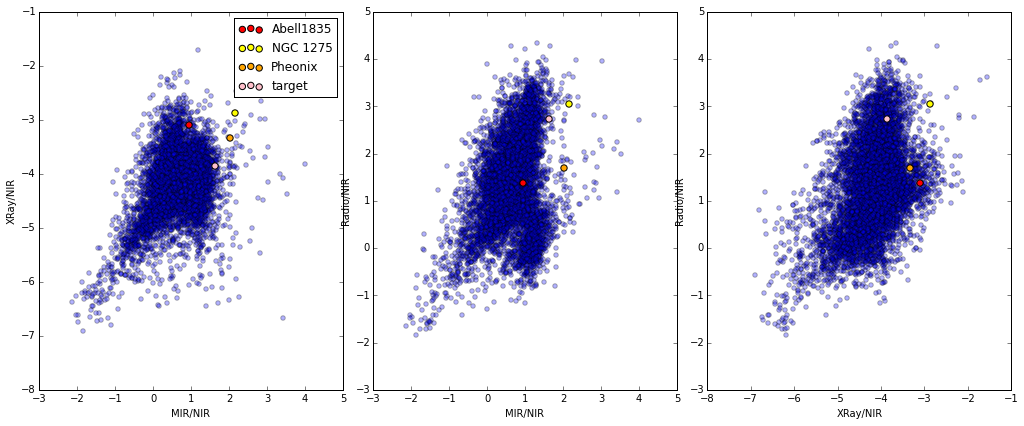

In [14]:
#mpld3.enable_notebook()
mpld3.disable_notebook()

fig, ax = plt.subplots(1, 3, figsize=(15,7))#, sharex="col", sharey="row")
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95,hspace=0.1, wspace=0.1)

mir=final['mir'].values
xray=final['xray'].values
radio=final['radio'].values

point=ax[0].scatter(mir,xray,alpha=0.3)
ax[0].scatter(abell2['mir'],abell2['xray'],alpha=1.0,c='red',label='Abell1835',s=40.0)
ax[0].scatter(ngc['mir'],ngc['xray'],alpha=1.0,c='yellow',label='NGC 1275',s=40.0)
ax[0].scatter(pheo2['mir'],pheo2['xray'],alpha=1.0,c='orange',label='Pheonix',s=40.0)
ax[0].scatter(target['mir'],target['xray'],alpha=1.0,c='pink',label='target',s=40.0)
ax[0].set_xlabel('MIR/NIR')
ax[0].set_ylabel('XRay/NIR')
ax[0].legend(loc='best')

point=ax[1].scatter(mir,radio,alpha=0.3)
ax[1].scatter(abell2['mir'],abell2['radio'],alpha=1.0,c='red',label='Abell1835',s=40.0)
ax[1].scatter(ngc['mir'],ngc['radio'],alpha=1.0,c='yellow',label='NGC 1275',s=40.0)
ax[1].scatter(pheo2['mir'],pheo2['radio'],alpha=1.0,c='orange',label='Pheonix',s=40.0)
ax[1].scatter(target['mir'],target['radio'],alpha=1.0,c='pink',label='target',s=40.0)
ax[1].set_xlabel('MIR/NIR')
ax[1].set_ylabel('Radio/NIR')

point=ax[2].scatter(xray,radio,alpha=0.3)
ax[2].scatter(abell2['xray'],abell2['radio'],alpha=1.0,c='red',label='Abell1835',s=40.0)
ax[2].scatter(ngc['xray'],ngc['radio'],alpha=1.0,c='yellow',label='NGC 1275',s=40.0)
ax[2].scatter(pheo2['xray'],pheo2['radio'],alpha=1.0,c='orange',label='Pheonix',s=40.0)
ax[2].scatter(target['xray'],target['radio'],alpha=1.0,c='pink',label='target',s=40.0)
ax[2].set_xlabel('XRay/NIR')
ax[2].set_ylabel('Radio/NIR')

plugins.connect(fig, plugins.LinkedBrush(point))

### Method 1: Cube uncertainty

In [315]:
#factor of 4 and 12, 12 respectively
ls=[]
for i in [-1.,0.,1.]:
    for j in [-1.,0.,1.]:
        for k in [-1.,0.,1.]:
            ls.append([i,j,k])

def inside(x,y,z,rx,ry,rz):
    return (x-pheo2['mir'])**2/rx**2+(y-pheo2['radio'])**2/ry**2+(z-pheo2['xray'])**2/rz**2

def inellips(x):
    rx=1.079
    ry=1.079
    rz=0.602
    x0=x['mir']
    y0=x['radio']
    z0=x['xray']
    ex=x['emir']
    ey=x['eradio']
    ez=x['exray']
    
    rs=[]
    for i in ls:
        r=inside(x0+ex*i[0],y0+ey*i[1],z0+ez*i[2],rx,ry,rz)
        if r <= 1.0:
            rs.append(r)
        else:
            pass

    if len(rs) >= 1:
        return len(rs)
    else:
        return np.nan

cut1=final
cut1['inside']=final.apply(inellips, axis=1)
cut=cut1.dropna()
cut.shape

(185, 51)

### Method 2: ellipsoid 

In [17]:
def hfactor(x,y,z,rx,ry,rz):
    return ((rx*ry*rz)**2./((x*ry*rz)**2.+(y*rx*rz)**2.+(z*rx*ry)**2.))**0.5

def inellips_v2(x):
    rx=1.079#0.954
    ry=1.079#0.954
    rz=0.602#0.477
    x0=x['mir']
    y0=x['radio']
    z0=x['xray']
    ex=x['emir']
    ey=x['eradio']
    ez=x['exray']
        
    h=hfactor(x0-pheo2['mir'],y0-pheo2['radio'],z0-pheo2['xray'],rx,ry,rz)
    dh=hfactor(x0-pheo2['mir'],y0-pheo2['radio'],z0-pheo2['xray'],ex,ey,ez)

    #print r, dr, h, dh
    if h+dh > 1.0:
        return h+dh
    else:
        return np.nan

    
#inellips_v2(final.loc[10])
cut1=final
cut1['inside']=final.apply(inellips_v2, axis=1)
cut=cut1.dropna()
cut.shape

(113, 53)

### Method 3 Vertical Cut
* the method that we end up using at the end with the region of interest from 3, 9, 9 (base on the calculation of uncertainty from ``z_uncertainty``

In [15]:
#factor of 3 and 9, 9 respectively
cut1=final
print cut1.shape, cut1.dropna().shape


cut2=final[(final['mir']+final['emir']>pheo2['mir']-np.log10(3.*3.)) &\
           (final['radio']+final['eradio']>pheo2['radio']-np.log10(3.*3.)) &\
           (final['xray']+final['exray']>pheo2['xray']-np.log10(3.))]

#cut2=final[(final['mir']>pheo2['mir']-np.log10(3.*3.)) &\
#           (final['radio']>pheo2['radio']-np.log10(3.*3.)) &\
#           (final['xray']>pheo2['xray']-np.log10(3.))]


#def incut(x):    
    
    
#print pheo2['mir'], pheo2['mir']-
print cut1.shape, cut2.shape
cut=cut2

(6897, 52) (3408, 52)
(6897, 52) (561, 52)


In [16]:
cut1

ra       dec        xc       exc   hr1  ehr1   hr2  ehr2  \
0      33.25959  84.33694  0.010360  0.004806  1.00  0.90  0.01  0.46   
1      65.18333  84.82361  0.016120  0.006578  0.32  0.43  0.50  0.39   
2      46.95958  82.46792  0.012750  0.006071  0.55  0.74 -0.20  0.42   
4      77.86000  83.48194  0.013020  0.005788  1.00  0.63  0.03  0.43   
6     195.46957  85.12889  0.028350  0.007482  1.00  0.22  0.36  0.24   
7     195.91458  84.78333  0.049290  0.010550  1.00  0.12  0.50  0.16   
8     185.84334  84.60500  0.013760  0.007345  1.00  0.59  0.60  0.33   
10    266.87582  82.45417  0.009736  0.003915  1.00  0.70  0.39  0.42   
12    275.87708  81.80833  0.018970  0.005118  0.35  0.27  0.17  0.28   
14    346.15543  82.07514  0.030740  0.007483  0.95  0.25  0.51  0.21   
15      3.29333  77.81264  0.035670  0.007437  0.92  0.18  0.67  0.21   
19     74.97250  80.18417  0.039980  0.010990  0.96  0.09  0.31  0.24   
20     85.32167  77.62444  0.035010  0.010970  0.51  0.33  0.43  0.36   
21     94.64958  78.35389  0.037670  0.010220  0.60  0.24  0.30  0.31   
23    112.71792  78.94264  0.033520  0.009539  0.32  0.28  0.69  0.24   
24    133.90666  78.22278  0.023970  0.010530  1.00  0.35 -0.05  0.38   
25    133.04916  76.45306  0.039200  0.011130  0.21  0.26  0.00  0.33   
26    172.45667  81.16097  0.026460  0.008688  0.24  0.32  0.42  0.40   
27    185.92667  80.66820  0.014900  0.006496  1.00  0.48 -0.30  0.43   
28    196.53250  80.13667  0.035440  0.009450  0.47  0.25  0.38  0.26   
30    220.03542  78.29514  0.046820  0.009840  0.09  0.21  0.29  0.24   
31    223.17084  76.76180  0.018500  0.005942  0.23  0.32 -0.07  0.38   
34    239.21333  81.48473  0.020110  0.005827  0.89  0.12  0.47  0.27   
35    236.65167  78.61486  0.027480  0.007098  0.45  0.25  0.19  0.26   
37    268.29584  81.45208  0.034900  0.006052  0.88  0.15  0.52  0.15   
38    253.27541  80.06389  0.022010  0.005240  0.66  0.27  0.55  0.25   
39    253.68207  79.53972  0.015600  0.004541  1.00  0.39  0.06  0.28   
45    260.99374  76.88903  0.012600  0.003557  0.56  0.36  0.30  0.28   
49    258.48917  76.05861  0.014770  0.004124  0.64  0.29  0.55  0.22   
50    278.03958  81.00681  0.041200  0.006866  0.78  0.12  0.43  0.16   
...         ...       ...       ...       ...   ...   ...   ...   ...   
9744  355.73624  -3.37431  0.183400  0.024420  0.37  0.12  0.10  0.15   
9745  355.80124 -36.63542  0.237000  0.053520 -0.58  0.17  1.00  1.10   
9746  355.88541  34.66597  0.411400  0.032830  0.90  0.03  0.35  0.07   
9748  355.91251   2.74583  0.057970  0.014730  0.06  0.26 -0.14  0.35   
9750  356.18375 -42.72208  0.211000  0.048860  0.37  0.25  0.65  0.39   
9751  356.35544  -5.53514  0.054110  0.015390  1.00  0.24  0.40  0.27   
9753  356.40833 -14.82333  0.114600  0.026260  0.24  0.23 -0.02  0.30   
9754  356.44794 -29.51486  0.079140  0.018720  0.82  0.18  0.60  0.20   
9755  356.47583  34.23861  0.218800  0.023940  0.62  0.09  0.13  0.12   
9756  356.65292   9.51014  0.090820  0.015720  0.70  0.14 -0.01  0.18   
9757  356.77335  51.70458  0.575200  0.035160  0.96  0.01  0.31  0.05   
9759  356.89417  27.31958  0.070550  0.016060  0.93  0.12  0.45  0.22   
9760  356.97540  54.60667  0.137100  0.018610  0.97  0.09  0.33  0.13   
9761  357.28207 -33.19667  0.458400  0.046140 -0.49  0.08 -0.05  0.20   
9763  357.44583 -23.87972  0.076660  0.017930 -0.34  0.20 -0.43  0.35   
9766  357.59836 -24.59792  0.135200  0.023660 -0.01  0.17 -0.18  0.23   
9767  357.62332 -26.34514  0.055760  0.016750 -0.09  0.30 -0.02  0.47   
9768  357.64459  29.49000  0.122100  0.024070  0.87  0.14 -0.04  0.20   
9769  357.64709 -30.09375  0.078830  0.020000 -0.23  0.22 -0.16  0.36   
9770  357.70959   6.15583  0.372200  0.042710  0.91  0.05  0.56  0.09   
9771  357.91959 -26.08403  0.616100  0.046320  0.49  0.06  0.36  0.08   
9772  357.98419  -1.15319  0.531000  0.039260  0.20  0.07  0.06  0.09   
9774  358.74167  -5.67556  0.090100  0.019270 -0.18  0.19  0.05  0.29  

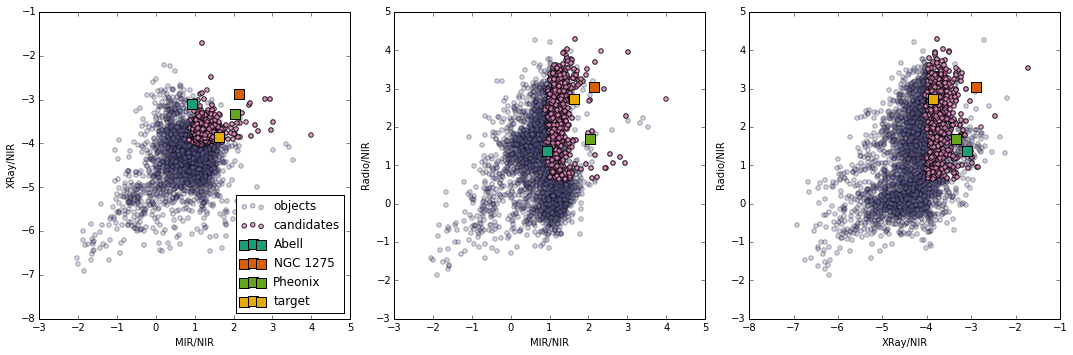

In [35]:
#mpld3.enable_notebook()
mpld3.disable_notebook()

fig, ax = plt.subplots(1, 3, figsize=(15,5))#, sharex="col", sharey="row")
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95,hspace=0.1, wspace=0.1)

mir=final.dropna()['mir'].values
xray=final.dropna()['xray'].values
radio=final.dropna()['radio'].values

point=ax[0].scatter(mir,xray,alpha=0.3, c='#7570b3', label='objects',s=20.)
ax[0].scatter(cut['mir'],cut['xray'],alpha=0.8,c='#e78ac3',label='candidates',s=20)
ax[0].scatter(abell2['mir'],abell2['xray'],alpha=1.0,c='#1b9e77',label='Abell',s=100.0,marker='s')
ax[0].scatter(ngc['mir'],ngc['xray'],alpha=1.0,c='#d95f02',label='NGC 1275',s=100.0,marker='s')
ax[0].scatter(pheo2['mir'],pheo2['xray'],alpha=1.0,c='#66a61e',label='Pheonix',s=100.0,marker='s')
ax[0].scatter(target['mir'],target['xray'],alpha=1.0,c='#e6ab02',label='target',s=100.0,marker='s')
ax[0].set_xlabel('MIR/NIR')
ax[0].set_ylabel('XRay/NIR')
ax[0].legend(loc='lower right')

point=ax[1].scatter(mir,radio,alpha=0.3, c='#7570b3', label='objects',s=20.)
ax[1].scatter(cut['mir'],cut['radio'],alpha=0.8,c='#e78ac3',label='candidates',s=20)
ax[1].scatter(abell2['mir'],abell2['radio'],alpha=1.0,c='#1b9e77',label='Abell',s=100.0,marker='s')
ax[1].scatter(ngc['mir'],ngc['radio'],alpha=1.0,c='#d95f02',label='NGC 1275',s=100.0,marker='s')
ax[1].scatter(pheo2['mir'],pheo2['radio'],alpha=1.0,c='#66a61e',label='Pheonix',s=100.0,marker='s')
ax[1].scatter(target['mir'],target['radio'],alpha=1.0,c='#e6ab02',label='target',s=100.0,marker='s')
ax[1].set_xlabel('MIR/NIR')
ax[1].set_ylabel('Radio/NIR')

point=ax[2].scatter(xray,radio,alpha=0.3, c='#7570b3', label='objects',s=20.)
ax[2].scatter(cut['xray'],cut['radio'],alpha=0.8,c='#e78ac3',label='candidates',s=20)
ax[2].scatter(abell2['xray'],abell2['radio'],alpha=1.0,c='#1b9e77',label='Abell',s=100.0,marker='s')
ax[2].scatter(ngc['xray'],ngc['radio'],alpha=1.0,c='#d95f02',label='NGC 1275',s=100.0,marker='s')
ax[2].scatter(pheo2['xray'],pheo2['radio'],alpha=1.0,c='#66a61e',label='Pheonix',s=100.0,marker='s')
ax[2].scatter(target['xray'],target['radio'],alpha=1.0,c='#e6ab02',label='target',s=100.0,marker='s')
ax[2].set_xlabel('XRay/NIR')
ax[2].set_ylabel('Radio/NIR')

plt.tight_layout()

plugins.connect(fig, plugins.LinkedBrush(point))

## How to use plotly with office option

In [42]:
import plotly as plotly

import plotly.plotly as py
from plotly.graph_objs import *

#print plotly.__version__            # version 1.9.x required
plotly.offline.init_notebook_mode()


trace0 = Scatter3d(
    x=mir,  # x coords
    y=radio,  # y coords
    z=xray,  # z coords
    mode='markers',
    name='candidates',
    marker=Marker(color='blue',symbol='dot',size=2,opacity=0.3)
)

def ellipse(u,v):
    x=pheo2['mir']+1.079*np.cos(u)*np.cos(v)
    y=pheo2['radio']+1.079*np.cos(u)*np.sin(v)
    z=pheo2['xray']+0.602*np.sin(u)
    return x,y,z

u=np.linspace(-np.pi/2,np.pi/2,200)
v=np.linspace(-np.pi,np.pi,200)
ugrid, vgrid = np.meshgrid(u,v)

x,y,z=ellipse(ugrid, vgrid)

#surface = Surface(x=x, y=y, z=z,opacity=0.8)
surface = Surface(x=x, y=y, z=z,opacity=0.8,showscale=False)#,colorscale='Greys')#,\
                 #contours=dict(x=dict(show=True, width=1),\
                 #              y=dict(show=True, width=1),\
                 #              z=dict(show=True, width=1)))

trace1 = Scatter3d(
    x=[abell2['mir']],  # x coords
    y=[abell2['radio']],  # y coords
    z=[abell2['xray']],  # z coords
    mode='markers',
    name='Abell',
    marker=Marker(color='red',symbol='dot',size=5,opacity=1.0)
)

trace2 = Scatter3d(
    x=[ngc['mir']],  # x coords
    y=[ngc['radio']],  # y coords
    z=[ngc['xray']],  # z coords
    mode='markers',
    name='NGC',
    marker=Marker(color='green',symbol='dot',size=5,opacity=1.0)
)

trace3 = Scatter3d(
    x=[pheo2['mir']],  # x coords
    y=[pheo2['radio']],  # y coords
    z=[pheo2['xray']],  # z coords
    mode='markers',
    name='Pheonix',
    marker=Marker(color='orange',symbol='dot',size=5,opacity=1.0)
)

trace5 = Scatter3d(
    x=[target['mir']],  # x coords
    y=[target['radio']],  # y coords
    z=[target['xray']],  # z coords
    mode='markers',
    name='Target',
    marker=Marker(color='purple',symbol='dot',size=5,opacity=1.0)
)

trace4 = Scatter3d(
    x=cut['mir'],  # x coords
    y=cut['radio'],  # y coords
    z=cut['xray'],  # z coords
    mode='markers',
    name='Cut',
    marker=Marker(color='violet',symbol='dot',size=3,opacity=1.0)
    #marker=Marker(color=cut['inside'],symbol='diamond',size=4,opacity=0.8,\
    #              colorscale='Reds',showscale=True,cmax=cut['inside'].max())
)


layout = Layout(
    title='Plot of Xray, MIR, Radio',
    scene=Scene(
        xaxis=XAxis(title='MIR/NIR'),
        yaxis=YAxis(title='Radio/NIR'),
        zaxis=ZAxis(title='Xray/NIR')))

# Package the trace dictionary into a data object
data = Data([trace0,trace1,trace2,trace3,trace5,trace4])#,surface])

fig = Figure(data=data, layout=layout)
plotly.offline.iplot(fig)
#py.iplot(fig)

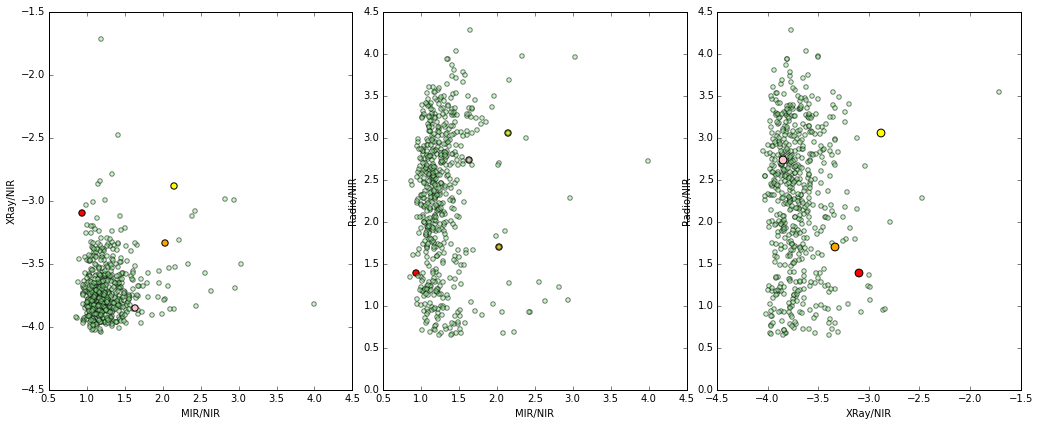

In [39]:
#mpld3.enable_notebook()
mpld3.disable_notebook()

fig, ax = plt.subplots(1, 3, figsize=(15,7))#, sharex="col", sharey="row")
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95,hspace=0.1, wspace=0.1)

mir=final['mir'].values
xray=final['xray'].values
radio=final['radio'].values

point=ax[0].scatter(cut['mir'],cut['xray'],alpha=0.5,c='lightgreen',label='Cut')
ax[0].scatter(abell2['mir'],abell2['xray'],alpha=1.0,c='red',label='Abell',s=40.0)
ax[0].scatter(ngc['mir'],ngc['xray'],alpha=1.0,c='yellow',label='NGC 1275',s=40.0)
ax[0].scatter(pheo2['mir'],pheo2['xray'],alpha=1.0,c='orange',label='Pheonix',s=40.0)
ax[0].scatter(target['mir'],target['xray'],alpha=1.0,c='pink',label='target',s=40.0)
ax[0].set_xlabel('MIR/NIR')
ax[0].set_ylabel('XRay/NIR')
#ax[0].legend(loc='best')

point=ax[1].scatter(abell2['mir'],abell2['radio'],alpha=1.0,c='red',label='Abell',s=40.0)
ax[1].scatter(ngc['mir'],ngc['radio'],alpha=1.0,c='yellow',label='NGC 1275',s=40.0)
ax[1].scatter(pheo2['mir'],pheo2['radio'],alpha=1.0,c='orange',label='Pheonix',s=40.0)
ax[1].scatter(target['mir'],target['radio'],alpha=1.0,c='pink',label='target',s=40.0)
ax[1].scatter(cut['mir'],cut['radio'],alpha=0.5,c='lightgreen',label='Cut')
ax[1].set_xlabel('MIR/NIR')
ax[1].set_ylabel('Radio/NIR')

point=ax[2].scatter(cut['xray'],cut['radio'],alpha=0.5,c='lightgreen',label='Cut')
ax[2].scatter(abell2['xray'],abell2['radio'],alpha=1.0,c='red',label='Abell',s=60.0)
ax[2].scatter(ngc['xray'],ngc['radio'],alpha=1.0,c='yellow',label='NGC 1275',s=60.0)
ax[2].scatter(pheo2['xray'],pheo2['radio'],alpha=1.0,c='orange',label='Pheonix',s=60.0)
ax[2].scatter(target['xray'],target['radio'],alpha=1.0,c='pink',label='target',s=60.0)
ax[2].set_xlabel('XRay/NIR')
ax[2].set_ylabel('Radio/NIR')
#ax[2].axis([-4.5,-2.5,0,4.5])


plugins.connect(fig, plugins.LinkedBrush(point))

In [25]:
for i in range(5):
    print cut['RA'].values[i], cut['DEC'].values[i] 
    
#cut['RA']

133.04933 76.4540577778
34.3791233333 73.8256644445
137.121913334 72.2754022222
156.653913334 70.5444716666
114.088956666 65.2220166667


## Looking at these objects

In [26]:
header_row=['row','input','sep','name', 'ra_s','dec_s','type','z','zqual','row2']
ned = pd.read_csv('/Users/taweewat/Documents/xray_project/candidates.txt',\
                  names=header_row, sep=r"|", skiprows=2)

In [ ]:
typ=[]
redshift=[]
reject=[]
ind=[]
i=0

for index, row in cut.iterrows():
    ned.loc[i,:]
    print i, row['RA'], row['DEC']
    t=raw_input('type g, qso, uv, radio, xray, s, vis, uve, gr, cl, bl> ')
    z=raw_input('redshift > ')
    r=raw_input('reject hz, lz, n > ')
    ind.append(index)
    typ.append(t)
    redshift.append(z)
    reject.append(r)
    if i % 10. == 1.:
        stop=raw_input('stop y/n')
        if stop == 'y':
            break
    i=i+1

In [108]:
j=0
for ind, i in cut.iterrows():
    print cut.index[j]
    j=j+1

25
66
80
91
173
178
194
276
355
393
414
575
577
609
658
665
667
681
687
725
840
866
867
872
920
924
948
987
990
1029
1107
1114
1119
1203
1242
1257
1284
1394
1417
1447
1480
1508
1520
1537
1555
1565
1710
1729
1748
1763
1764
1791
1807
1812
1841
1846
1854
1870
1875
1898
1905
1975
2033
2127
2224
2241
2270
2287
2318
2364
2374
2440
2443
2474
2518
2541
2555
2564
2569
2581
2583
2585
2592
2606
2617
2706
2711
2756
2771
2782
2784
2828
2849
2862
2918
2922
2936
2960
3008
3010
3069
3088
3189
3220
3253
3257
3290
3336
3459
3490
3524
3538
3634
3676
3723
3733
3742
3772
3812
3850
3908
3938
3947
3965
3968
3973
4036
4082
4103
4111
4114
4253
4257
4353
4360
4366
4388
4395
4416
4437
4438
4487
4494
4496
4552
4583
4590
4676
4685
4697
4700
4709
4710
4715
4719
4736
4744
4776
4834
4871
4876
4890
4932
4955
4981
5017
5021
5025
5041
5044
5060
5135
5144
5164
5185
5187
5195
5305
5306
5314
5321
5336
5366
5375
5431
5433
5460
5463
5478
5482
5487
5516
5569
5578
5625
5649
5655
5699
5732
5752
5765
5822
5848
5859
5868
5886
588

In [77]:
ra=cut['ra'].values

In [81]:
ra=ra+1

In [83]:
#combine array at the end
df3 = pd.DataFrame(ra, index=cut.index)
df3.columns = ['nra']
r=pd.concat([cut, df3], axis=1)

In [23]:
cut

ra       dec        xc       exc   hr1  ehr1   hr2  ehr2  \
25    133.04916  76.45306   0.03920  0.011130  0.21  0.26  0.00  0.33   
66     34.37958  73.82569   0.03880  0.008869  1.00  0.21  0.60  0.16   
80    137.11916  72.27611   0.03119  0.010460  0.13  0.35  0.31  0.39   
91    156.65541  70.54361   0.03453  0.012260  0.01  0.36 -0.79  0.78   
173   114.08708  65.22320   0.02377  0.010900  0.69  0.35  0.93  1.13   
178   145.94792  69.14014   0.02033  0.010390  1.00  0.71  0.52  0.82   
194   175.36624  65.61042   0.03688  0.014920 -0.04  0.36  0.31  0.46   
276   263.22708  65.55666   0.03448  0.003481  0.78  0.08  0.09  0.09   
355   101.25667  60.41708   0.03999  0.013210  1.00  0.28 -0.10  0.35   
393   193.88333  59.66583   0.02586  0.009629  0.45  0.41  0.08  0.40   
414   220.38042  60.31264   0.03590  0.012580 -0.51  0.22 -0.09  0.48   
575    74.05375  54.00708   0.02205  0.008367  0.83  0.31  1.00  0.62   
577    85.31667  55.85139   0.02577  0.010060  0.58  0.38  0.44  1.48   
609   146.89792  58.51431   0.03180  0.011220 -0.49  0.23 -1.00  0.89   
658   209.57083  57.86986   0.04580  0.010870 -0.22  0.21 -0.16  0.32   
665   207.40125  53.68958   0.04549  0.013470  0.17  0.30 -0.31  0.35   
667   219.93500  58.46722   0.04816  0.014450 -0.66  0.19  0.06  0.63   
681   227.41917  57.30639   0.03136  0.008230 -0.33  0.20 -0.08  0.34   
687   228.82793  55.26139   0.03964  0.008074 -0.05  0.19  0.09  0.25   
725   242.31252  53.90931   0.01970  0.006212 -0.03  0.26  0.12  0.33   
840    33.38167  50.66833   0.04746  0.010910  1.00  0.12  0.19  0.21   
866   116.00291  51.82778   0.04949  0.013160  0.04  0.29 -0.06  0.41   
867   110.75958  50.91958   0.06264  0.020450  1.00  0.48  0.82  0.39   
872   122.90000  48.52306   0.03528  0.010960  0.17  0.34  0.47  0.33   
920   167.77333  52.46750   0.01707  0.008115 -0.83  0.16  0.00  0.00   
924   167.75334  49.33250   0.04946  0.012810  0.14  0.27  0.51  0.27   
948   195.57292  48.32444   0.04489  0.012020 -0.35  0.22  0.50  0.35   
987   228.79916  47.91417   0.02113  0.009255  0.57  0.58 -0.51  1.10   
990   236.26208  51.58472   0.03490  0.008227  0.08  0.21  0.47  0.22   
1029  266.20917  51.06597   0.02923  0.005186  0.28  0.18  0.10  0.21   
...         ...       ...       ...       ...   ...   ...   ...   ...   
9554  334.28040 -30.57806   0.07788  0.023570 -1.00  0.14  0.00  0.00   
9560  334.93585  21.34847   0.08019  0.014260  0.34  0.17  0.21  0.21   
9564  335.31210 -28.07222   0.06022  0.018760 -0.19  0.27 -0.19  0.41   
9568  335.78000 -34.92750   0.09153  0.022880 -0.48  0.21  1.00  1.03   
9571  336.41083  21.30181   0.13050  0.022660  0.76  0.14  0.47  0.15   
9577  336.98001 -43.56472   0.07242  0.019110 -0.91  0.12  0.31  1.98   
9581  337.66333 -39.71292   0.54610  0.045910 -0.05  0.08  0.12  0.12   
9602  340.25873  27.54681   0.07347  0.013810  0.81  0.12  0.11  0.20   
9603  340.59460 -60.74472   0.12630  0.020510  0.11  0.16  0.04  0.21   
9614  341.80667   2.06944   0.10810  0.030570  1.00  0.16  0.02  0.28   
9618  342.07791 -10.26597   0.13280  0.034170  0.36  0.22  0.54  0.46   
9620  342.49710 -33.25597   0.06391  0.019810  0.00  0.29  0.80  0.27   
9630  343.49167  16.14861   0.60940  0.057190  0.96  0.03  0.26  0.09   
9632  343.54126  24.75639   0.05364  0.011660  1.00  0.10  0.09  0.21   
9635  344.11252 -65.55556   0.12800  0.019710  0.01  0.14  0.02  0.20   
9652  345.76541 -18.69194   0.49660  0.062210  0.15  0.12  0.09  0.17   
9655  345.92999 -68.12695   0.10910  0.017510  0.08  0.15  0.11  0.19   
9660  346.72708 -34.65264   0.11010  0.031310 -0.34  0.25  0.73  0.74   
9670  347.54208  10.79208   0.06489  0.013570  0.53  0.19  0.15  0.22   
9696  349.98541  40.53444   0.08095  0.015960  0.88  0.09 -0.01  0.20   
9706  350.85583  58.81055  49.03000  0.202700  0.99  0.00  0.81  0.00   
9712  351.36456 -48.00681   0.15410  0.032200 -0.52  0.16 -0.31  0.65   
9718  352.04333  29.61764   0.05985  0.012910  0.56  0.21  0.64  0.22  

## Output the cut file

In [26]:
cut.to_csv('/Users/taweewat/Documents/xray_project/result/cut-01.csv', index=False)